# Preprocessing trial acquisitions (calcium imaging)
* 1. Creating reference images
* 2. Rigid motion correction (phase correlation)
* 3. Deformable motion correction (optical flow)



In [1]:
import os
import numpy as np
import random
from scipy.ndimage import shift
from tifffile import imread, imwrite
import matplotlib.pyplot as plt
import napari

# skimage imports
from skimage.exposure import match_histograms, equalize_adapthist, rescale_intensity, equalize_hist
from skimage.registration import phase_cross_correlation, optical_flow_ilk
from skimage.transform import warp

from pystackreg import StackReg

from scripts.config_model import save_experiment_config, tree
from scripts.sample_db import SampleDB
from scripts.utils.image_utils import load_tiff_as_hyperstack, save_array_as_hyperstack_tiff

In [2]:
def load_reference_images():
    if os.path.exists(ref_images_path):
        ref_images = imread(ref_images_path)
        print("Reference trial images loaded")
    else:
        ref_images = compute_reference_images()
        save_array_as_hyperstack_tiff(ref_images_path, ref_images)
    return ref_images






In [3]:
# Step 1: Load the sample database
db_path = r'\\tungsten-nas.fmi.ch\tungsten\scratch\gfriedri\montruth\sample_db.csv'
sample_db = SampleDB()
sample_db.load(db_path)
print(sample_db)

SampleDB(sample_ids=['20220426_RM0008_130hpf_fP1_f3', '20220118_RM0012_124hpf_fP8_f2', '20220427_RM0008_126hpf_fP3_f3'])


In [4]:
# Step 2: Load experiment configuration
sample_id = '20220118_RM0012_124hpf_fP8_f2'
exp = sample_db.get_sample(sample_id)

In [5]:
# Step 3: Making shortcuts of sample parameters/information
sample = exp.sample
root_path = exp.paths.root_path
trials_path = exp.paths.trials_path
anatomy_path = exp.paths.anatomy_path
em_path = exp.paths.em_path
n_planes = exp.params_lm.n_planes
n_frames = exp.params_lm.n_frames
n_slices = exp.params_lm.lm_stack_range
doubling = 2 if exp.params_lm.doubling else 1

# Calculating number of frames per trial 
n_frames_trial = n_frames // n_planes
exp.params_lm["n_frames_trial"] = n_frames_trial

# Getting paths of the trial acquisitions
raw_trial_paths = os.listdir(os.path.join(trials_path, "raw"))
n_trials = len(raw_trial_paths)
exp.params_lm["n_trials"] = n_trials
ignore_until_frame = exp.params_lm.shutter_delay_frames  # edit if you want to avoid summing out motor movements at the beginning of acquisition

# Define the path for the preprocessed folder
processed_folder = os.path.join(trials_path, "processed")
os.makedirs(processed_folder, exist_ok=True)

ref_images_path = os.path.join(processed_folder, f"sum_raw_trials_{sample.id}.tif")


Reference trial images loaded
Starting rigid parameters computation
Processing plane 0
Processing plane 1
Processing plane 2
Processing plane 3
Processing plane 4
Processing plane 5
Processing plane 6
Processing plane 7


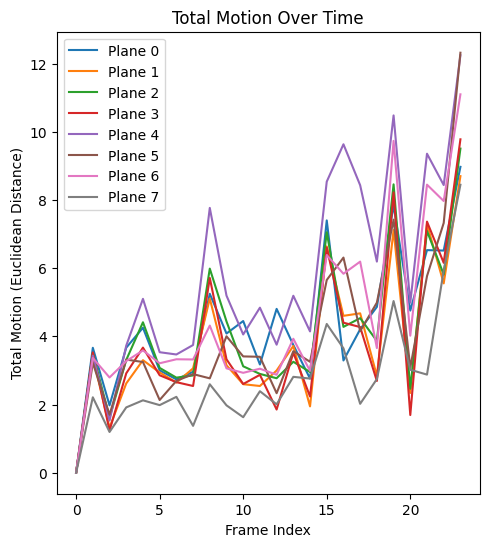

In [6]:
# Step 5: Compute phase correlation for each frame against the reference or load existing parameters

# Load reference images
ref_images = load_reference_images()
aligned_frames_path = os.path.join(processed_folder, f"sum_rigid_corrected_trials_{exp.sample.id}.tif")
rigid_params_path = os.path.join(processed_folder, "rigid_params.npy")

if os.path.exists(rigid_params_path):
    rigid_params = np.load(rigid_params_path)
    print("Rigid parameters loaded")
else:
    aligned_frames = np.zeros_like(ref_images)
    print("Starting rigid parameters computation")
    rigid_params = np.zeros((n_planes * doubling, n_trials, 2))
    total_motion = np.zeros((n_planes * doubling, n_trials))

    for plane in range(n_planes * doubling):
        print(f"Processing plane {plane}")
        for trial in range(n_trials):
            ref_trial = ref_images[plane, 0, :, :]
            current_trial = ref_images[plane, trial, :, :]  #match_histograms(, ref_trial)
            '''
            X = phase_cross_correlation(ref_trial, current_trial, upsample_factor=1, space='real')
            rigid_params[plane, ii, 0] = X[0][0]  # x-displacement
            rigid_params[plane, ii, 1] = X[0][1]  # y-displacement
            total_motion[plane, ii] = np.sqrt(X[0][0] ** 2 + X[0][1] ** 2)
            '''
            # using pystackreg to align frames (https://bigwww.epfl.ch/thevenaz/turboreg/)
            sr = StackReg(StackReg.TRANSLATION)
            warped_trial = sr.register_transform(ref_trial,current_trial)
            
            # Get the transformation matrix
            transformation_matrix = sr.get_matrix()               
            tx = transformation_matrix[0, 2]
            ty = transformation_matrix[1, 2]
            
            #print(f"Translation shifts: tx = {tx}, ty = {ty}")

            rigid_params[plane, trial, 0] = tx  # x-displacement
            rigid_params[plane, trial, 1] = ty  # y-displacement
            total_motion[plane, trial] = np.sqrt(tx ** 2 + ty ** 2)
            
            # Apply the rigid shift
            shifted_frame = shift(current_trial, rigid_params[plane, trial], order=3, prefilter=True)

            # Match histograms to the reference frame to ensure consistent intensity
            aligned_frames[plane, trial, :, :] = match_histograms(shifted_frame, ref_trial)

    # Plot total motion and shifts
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    for plane in range(n_planes * doubling):
        plt.plot(total_motion[plane, :], label=f'Plane {plane}')
    plt.title("Total Motion Over Time")
    plt.xlabel("Frame Index")
    plt.ylabel("Total Motion (Euclidean Distance)")
    plt.legend()
    plt.show()

    np.save(rigid_params_path, rigid_params)
    save_array_as_hyperstack_tiff(aligned_frames_path, aligned_frames)

In [7]:

# Visualize the alignment
viewer = napari.Viewer()
viewer.add_image(ref_images, name='ref_frames')
viewer.add_image(aligned_frames, name='aligned_images')

<Image layer 'aligned_images' at 0x1d727762da0>

In [8]:
# Step 6: Compute the optical flow with reference to the first image or load existing parameters
elastic_params_path = os.path.join(processed_folder, "elastic_params.npy")

if os.path.exists(elastic_params_path):
    elastic_params = np.load(elastic_params_path)
    print("Elastic parameters loaded")
else:
    print("Starting elastic parameters computation")
    elastic_params = np.zeros((n_planes * doubling, n_trials, 2, ref_images.shape[-2], ref_images.shape[-1]))
    warped_movie = np.zeros_like(aligned_frames)

    for plane in range(n_planes * doubling):
        ref_image = aligned_frames[plane, 0]
        nr, nc = ref_image.shape
        print(f"Starting plane {plane}")

        for trial in range(n_trials):
            print(f"Warping frame {trial + 1}/{n_trials}")
            frame = aligned_frames[plane, trial, :, :]
            v, u = optical_flow_ilk(ref_image, frame, radius=15)
            row_coords, col_coords = np.meshgrid(np.arange(nr), np.arange(nc), indexing='ij')
            warped_frame = warp(frame, np.array([row_coords + v, col_coords + u]), mode='edge')
            warped_frame = match_histograms(warped_frame, ref_image)
            warped_movie[plane, trial, :, :] = warped_frame
            elastic_params[plane, trial, 0] = v
            elastic_params[plane, trial, 1] = u

    np.save(elastic_params_path, elastic_params)
    print(f"saved elastic parameters in {elastic_params_path}")
    elastic_corrected_path = os.path.join(processed_folder, f"sum_elastic_corrected_trials_{exp.sample.id}.tif")
    save_array_as_hyperstack_tiff(elastic_corrected_path, warped_movie)

Starting elastic parameters computation
Starting plane 0
Warping frame 1/24
Warping frame 2/24
Warping frame 3/24
Warping frame 4/24
Warping frame 5/24
Warping frame 6/24
Warping frame 7/24
Warping frame 8/24
Warping frame 9/24
Warping frame 10/24
Warping frame 11/24
Warping frame 12/24
Warping frame 13/24
Warping frame 14/24
Warping frame 15/24
Warping frame 16/24
Warping frame 17/24
Warping frame 18/24
Warping frame 19/24
Warping frame 20/24
Warping frame 21/24
Warping frame 22/24
Warping frame 23/24
Warping frame 24/24
Starting plane 1
Warping frame 1/24
Warping frame 2/24
Warping frame 3/24
Warping frame 4/24
Warping frame 5/24
Warping frame 6/24
Warping frame 7/24
Warping frame 8/24
Warping frame 9/24
Warping frame 10/24
Warping frame 11/24
Warping frame 12/24
Warping frame 13/24
Warping frame 14/24
Warping frame 15/24
Warping frame 16/24
Warping frame 17/24
Warping frame 18/24
Warping frame 19/24
Warping frame 20/24
Warping frame 21/24
Warping frame 22/24
Warping frame 23/24
Warp

In [9]:
# Step 7: Apply rigid and elastic transformation to each frame of each trial
for trial_idx, trial_path in enumerate(raw_trial_paths):
    print(f"  Processing trial {trial_idx + 1}/{n_trials}")
    raw_movie = load_tiff_as_hyperstack(os.path.join(trials_path, "raw", trial_path), n_slices=exp.params_lm.n_planes,
                                        doubling=True)

    n_planes, n_frames, height, width = raw_movie.shape
    print(raw_movie.shape)
    transformed_movie = np.zeros_like(raw_movie, dtype=np.float32)

    for plane in range(n_planes):
        print(f"  Processing plane {plane + 1}/{n_planes}")
        Xs, Ys = rigid_params[plane, trial_idx, 0], rigid_params[plane, trial_idx, 1]
        v, u = elastic_params[plane, trial_idx, 0], elastic_params[plane, trial_idx, 1]

        for frame in range(n_frames):
            shifted_frame = shift(raw_movie[plane, frame, :, :].astype(np.float32), (Xs, Ys), order=3, prefilter=True)
            row_coords, col_coords = np.meshgrid(np.arange(height), np.arange(width), indexing='ij')
            warped_frame = warp(shifted_frame, np.array([row_coords + v, col_coords + u]), mode='edge')
            matched_frame = match_histograms(warped_frame, raw_movie[plane, frame, :, :].astype(np.float32))
            transformed_movie[plane, frame, :, :] = matched_frame

    transformed_trial_path = os.path.join(processed_folder, f"motion_corrected_{trial_path}")
    save_array_as_hyperstack_tiff(transformed_trial_path, transformed_movie)
    print(f"Transformed trial {trial_idx} saved at {transformed_trial_path}")

# Visualize the transformed movie (Optional)
viewer.add_image(transformed_movie, name='transformed_movie')
viewer.add_image(raw_movie, name='raw_movie')

# Save experiment configuration
save_experiment_config(exp, exp.paths.config_path)
tree(exp)


  Processing trial 1/24
\\tungsten-nas.fmi.ch\tungsten\scratch\gfriedri\montruth\2P_RawData\2022-01-18\f2\trials\raw\20220118_RM0012_124hpf_fP8_f2_t1_o1Ala_001_.tif loaded.
(8, 300, 256, 512)
  Processing plane 1/8
  Processing plane 2/8
  Processing plane 3/8
  Processing plane 4/8
  Processing plane 5/8
  Processing plane 6/8
  Processing plane 7/8
  Processing plane 8/8
Transformed trial 0 saved at \\tungsten-nas.fmi.ch\tungsten\scratch\gfriedri\montruth\2P_RawData\2022-01-18\f2\trials\processed\motion_corrected_20220118_RM0012_124hpf_fP8_f2_t1_o1Ala_001_.tif
  Processing trial 2/24
\\tungsten-nas.fmi.ch\tungsten\scratch\gfriedri\montruth\2P_RawData\2022-01-18\f2\trials\raw\20220118_RM0012_124hpf_fP8_f2_t1_o2Ser_001_.tif loaded.
(8, 300, 256, 512)
  Processing plane 1/8
  Processing plane 2/8
  Processing plane 3/8
  Processing plane 4/8
  Processing plane 5/8
  Processing plane 6/8
  Processing plane 7/8
  Processing plane 8/8
Transformed trial 1 saved at \\tungsten-nas.fmi.ch\tung